In [2]:
'''
This script attempts to replicate the results of Mineault et al. showing a decrease in the decoder error during locomotion
Author: Jonathan Gant
Date: 29.08.2024
'''

import numpy as np
import matplotlib.pyplot as plt
from utilities import calc_entropy
from tqdm import tqdm
import h5py
import os
import bottleneck as bn

# Set random seed for reproducibility
np.random.seed(0)

# load in the data
all_gabor_responses = h5py.File('../results/new_nat_videos_gabor_responses_full_res_more_low_freq_z_score.h5', 'r')

# video size
resolution_height = 1080
resolution_width = 1920

# fov
horizontal_fov = 92
vertical_fov = 61

# conversion factor of pixels to degrees
horizontal_pixels_per_degree = resolution_width / horizontal_fov
vertical_pixels_per_degree = resolution_height / vertical_fov

# average of the conversion factors to the nearest integer
pixels_per_degree = np.ceil((horizontal_pixels_per_degree + vertical_pixels_per_degree) / 2)
print(pixels_per_degree)

# data hyperparameters
orientation_arr = all_gabor_responses['orientation_arr'][()]
phase_arr = all_gabor_responses['phase_arr'][()]
position_arr = all_gabor_responses['position_arr'][()]
wavelength_arr = all_gabor_responses['wavelength_arr'][()]
freq_arr = pixels_per_degree / wavelength_arr
filter_size = (resolution_height, resolution_width)
print(freq_arr)

20.0
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12]


In [3]:
import bottleneck as bn

environments = ['field', 'forest', 'orchard', 'tall_grass', 'pond']

stationary_stim_SD = []
moving_stim_SD = []
stationary_stim = []
moving_stim = []

fps = 30
window_length = np.array([5]) # seconds
window_size = window_length * fps
print(window_size)
num_samples = 1740

# get the responses for each environment
for i in range(len(window_size)):
    stationary_stim_SD_temp = []
    moving_stim_SD_temp = []
    stationary_stim_temp = []
    moving_stim_temp = []
    for env_key in environments:
        all_gabor_responses_env = all_gabor_responses[env_key]
        print(all_gabor_responses_env.keys())
        for vid_key in all_gabor_responses_env.keys():
            # compute the moving SD
            resp_SD = bn.move_std(all_gabor_responses_env[vid_key][()], window=window_size[i], min_count=window_size[i], axis=-1)[:, :, :, :, :num_samples]
            if 'stationary' in vid_key:
                stationary_stim_SD_temp.append(resp_SD)
                stationary_stim_temp.append(all_gabor_responses_env[vid_key][()])
            if 'moving' in vid_key and 'free_moving' not in vid_key:
                moving_stim_SD_temp.append(resp_SD)
                moving_stim_temp.append(all_gabor_responses_env[vid_key][()])
    stationary_stim_SD.append(stationary_stim_SD_temp)
    moving_stim_SD.append(moving_stim_SD_temp)
    stationary_stim.append(stationary_stim_temp)
    moving_stim.append(moving_stim_temp)

[150]
<KeysViewHDF5 ['free_moving_1', 'free_moving_10', 'free_moving_2', 'free_moving_3', 'free_moving_4', 'free_moving_5', 'free_moving_6', 'free_moving_7', 'free_moving_8', 'free_moving_9', 'moving_1', 'moving_10', 'moving_2', 'moving_3', 'moving_4', 'moving_5', 'moving_6', 'moving_7', 'moving_8', 'moving_9', 'stationary_1', 'stationary_10', 'stationary_2', 'stationary_3', 'stationary_4', 'stationary_5', 'stationary_6', 'stationary_7', 'stationary_8', 'stationary_9']>
<KeysViewHDF5 ['free_moving_1', 'free_moving_10', 'free_moving_2', 'free_moving_3', 'free_moving_4', 'free_moving_5', 'free_moving_6', 'free_moving_7', 'free_moving_8', 'free_moving_9', 'moving_1', 'moving_10', 'moving_2', 'moving_3', 'moving_4', 'moving_5', 'moving_6', 'moving_7', 'moving_8', 'moving_9', 'stationary_1', 'stationary_10', 'stationary_2', 'stationary_3', 'stationary_4', 'stationary_5', 'stationary_6', 'stationary_7', 'stationary_8', 'stationary_9']>
<KeysViewHDF5 ['free_moving_1', 'free_moving_10', 'free_

In [4]:
stationary_stim_SD = np.array(stationary_stim_SD)
moving_stim_SD = np.array(moving_stim_SD)

In [5]:
windowed_std_stationary_responses = np.nanmean(stationary_stim_SD[0, :, :, :, :, :, :], axis=(0, -1))
windowed_std_moving_responses = np.nanmean(moving_stim_SD[0, :, :, :, :, :, :], axis=(0, -1))

In [6]:
20/wavelength_arr

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12])

In [7]:
# optimize nonlinearities using lookup table
dir_name = 'gaussian_optimization_analytic_fast' # 'all_sigma_more_bins_zscored_data'# 'higher_sigma_for_zscored_data' # 'more_sigma_bins_gaussian_results' # 'even_more_sigma_bins_gaussian_results'

MI_arr = np.load(dir_name + '/MI_arr.npy')
# stimulus_entropy = np.load(dir_name + '/stimulus_entropy.npy')
average_response_arr = np.load(dir_name + '/average_response_arr.npy')

# stimulus_bins = np.load(dir_name + '/stimulus_bins.npy') # np.linspace(-30, 30, 200)

# Define the range of k and L values for grid search
k_arr = np.load(dir_name + '/k_arr.npy') # np.logspace(-2, 2, num_bins) # 5*np.logspace(-2, 0, 100)
L_arr = np.load(dir_name + '/L_arr.npy') # np.arange(0.02, 4.02, .02) # np.arange(0.05, 5.05, .05)
sigma_arr = np.load(dir_name + '/sigma_arr.npy') # 5*np.logspace(-2, 1, num_bins) # np.logspace(-2, 2, num_bins)

# for each sigma compute the optimal parameters for a range of different lambdas
lambda_arr = np.arange(0, 2.25, 0.25)
optimal_k = np.zeros((len(sigma_arr), len(lambda_arr)))
optimal_L = np.zeros((len(sigma_arr), len(lambda_arr)))

# import gaussian filter to involve
from scipy.ndimage import gaussian_filter

for i, lambda_ in enumerate(lambda_arr):
    utility = MI_arr - lambda_ * average_response_arr
    print(utility.shape)
    # utility = gaussian_filter(utility, sigma=4, axes=(1, 2))
    for j, sigma in enumerate(sigma_arr):
        optimal_k[j, i] = k_arr[np.unravel_index(np.argmax(utility[j, :, :]), utility[j, :, :].shape)[0]]
        optimal_L[j, i] = L_arr[np.unravel_index(np.argmax(utility[j, :, :]), utility[j, :, :].shape)[1]]

(280, 200, 200)
(280, 200, 200)
(280, 200, 200)
(280, 200, 200)
(280, 200, 200)
(280, 200, 200)
(280, 200, 200)
(280, 200, 200)
(280, 200, 200)


In [8]:
# loop over all orientations and phases and wavelengths and compute the optimal parameters for each
optimal_k_arr_moving = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_L_arr_moving = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_k_arr_stationary = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_L_arr_stationary = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))

for i, orientation in tqdm(enumerate(orientation_arr)):
    print("orientation: " + str(orientation))
    for j, phase in enumerate(phase_arr):
        for l, wavelength in enumerate(wavelength_arr):
            for m, position in enumerate(position_arr):
                test_moving_std = windowed_std_moving_responses[i, j, l, m]
                test_stationary_std = windowed_std_stationary_responses[i, j, l, m]
                for n, lambda_ in enumerate(lambda_arr):
                    moving_idx = np.argmin(np.abs(sigma_arr - test_moving_std))
                    optimal_k_arr_moving[i, j, l, m, n] = optimal_k[moving_idx, n]
                    optimal_L_arr_moving[i, j, l, m, n] = optimal_L[moving_idx, n]
                    stationary_idx = np.argmin(np.abs(sigma_arr - test_stationary_std))
                    optimal_k_arr_stationary[i, j, l, m, n] = optimal_k[stationary_idx, n]
                    optimal_L_arr_stationary[i, j, l, m, n] = optimal_L[stationary_idx, n]

2it [00:00, 15.95it/s]

orientation: 0.0
orientation: 22.5
orientation: 45.0
orientation: 67.5


6it [00:00, 16.18it/s]

orientation: 90.0
orientation: 112.5
orientation: 135.0


8it [00:00, 16.06it/s]

orientation: 157.5


In [9]:
optimal_L_arr_moving[:, :, :, :, 2].max()

2.05

In [10]:
# Define the logistic non-linearity
def logistic_func(s, s_0=0, k=1, L=1):
    try:
        return L / (1 + np.exp(-k * (s - s_0)))
    except OverflowError:
        return 0

In [11]:
def calc_moving_entropy_mean(values, binning_scheme, window_length):
    moving_entropy = np.zeros(int(len(values)/window_length))
    moving_mean = np.zeros(int(len(values)/window_length))
    for i, val in enumerate(np.arange(0, len(values), window_length)):
        if val % window_length == 0:
            windowed_values = values[val:val+window_length]
            hist_values, _ = np.histogram(windowed_values, bins=binning_scheme, weights=np.ones_like(windowed_values)/len(windowed_values))
            # hist_values += 1e-10
            hist_values /= np.sum(hist_values)
            # find where hist_values is nonzero
            non_zero_val = hist_values > 0
            entropy = -np.sum(hist_values[non_zero_val]*np.log2(hist_values[non_zero_val]))
            moving_entropy[i] = entropy
            moving_mean[i] = np.mean(windowed_values)
    return moving_entropy, moving_mean

In [12]:
freq_arr

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12])

In [54]:
# define a set of stimuli
import bottleneck as bn

n_bins = 23
window_size = 1000
T = 100*window_size
rng = np.random.default_rng()

stim_SD = 50
max_L = 1.1

stimuli = rng.laplace(0, stim_SD, size=T)
# print(stimulus_entropy)


lambda_idx = 4
bias = 0
response_bins = np.linspace(0, max_L, n_bins)

moving_entropy_arr_stat_mov = np.zeros((len(orientation_arr), len(phase_arr), len(position_arr), len(wavelength_arr), int(T//window_size)))
moving_entropy_arr_mov_stat = np.zeros((len(orientation_arr), len(phase_arr), len(position_arr), len(wavelength_arr), int(T//window_size)))
moving_mean_arr_stat_mov = np.zeros((len(orientation_arr), len(phase_arr), len(position_arr), len(wavelength_arr), int(T//window_size)))
moving_mean_arr_mov_stat = np.zeros((len(orientation_arr), len(phase_arr), len(position_arr), len(wavelength_arr), int(T//window_size)))
responses_moving = np.zeros((len(orientation_arr), len(phase_arr), len(position_arr), len(wavelength_arr), T))
responses_stationary = np.zeros((len(orientation_arr), len(phase_arr), len(position_arr), len(wavelength_arr), T))
for i, ori in tqdm(enumerate(orientation_arr)):
    for j, phase in enumerate(phase_arr):
        for l, pos in enumerate(position_arr):
            for m, wavelength in enumerate(wavelength_arr):
                ori_idx = i
                phase_idx = j
                pos_idx = l
                freq_idx = m
                slope_stationary = optimal_k_arr_stationary[ori_idx, phase_idx, freq_idx, pos_idx, lambda_idx]
                max_L_stationary = optimal_L_arr_stationary[ori_idx, phase_idx, freq_idx, pos_idx, lambda_idx]
                slope_moving = optimal_k_arr_moving[ori_idx, phase_idx, freq_idx, pos_idx, lambda_idx]
                max_L_moving = optimal_L_arr_moving[ori_idx, phase_idx, freq_idx, pos_idx, lambda_idx]

                stationary_response = logistic_func(stimuli, k=slope_stationary, L=max_L_stationary, s_0=bias)
                moving_response = logistic_func(stimuli, k=slope_moving, L=max_L_moving, s_0=bias)

                responses_stationary[i, j, l, m, :] = stationary_response
                responses_moving[i, j, l, m, :] = moving_response

                # total_responses_stat_mov = np.concatenate((stationary_response[:T//2], moving_response[T//2:]))
                # total_responses_mov_stat = np.concatenate((moving_response[:T//2], stationary_response[T//2:]))
                # moving_entropy_stat_mov, moving_mean_stat_mov = calc_moving_entropy_mean(total_responses_stat_mov, response_bins, window_size)
                # moving_entropy_mov_stat, moving_mean_mov_stat = calc_moving_entropy_mean(total_responses_mov_stat, response_bins, window_size)
                # # moving_MI = calc_moving_MI(stimuli, total_responses, np.linspace(-3*stim_SD, 3*stim_SD, n_bins), np.linspace(0, max_L, n_bins), window_size)[:-window_size]
                # moving_entropy_arr_stat_mov[i, j, l, m] = moving_entropy_stat_mov
                # moving_entropy_arr_mov_stat[i, j, l, m] = moving_entropy_mov_stat
                # moving_mean_arr_stat_mov[i, j, l, m] = moving_mean_stat_mov
                # moving_mean_arr_mov_stat[i, j, l, m] = moving_mean_mov_stat
                # moving_MI_arr[i, j, l, m] = moving_MI

0it [00:00, ?it/s]

8it [00:10,  1.35s/it]


In [30]:
avg_moving_mean_stat_mov = np.mean(moving_mean_arr_stat_mov, axis=(0, 1, 2, 3))
avg_moving_mean_mov_stat = np.mean(moving_mean_arr_mov_stat, axis=(0, 1, 2, 3))
avg_moving_entropy_stat_mov = np.mean(moving_entropy_arr_stat_mov, axis=(0, 1, 2, 3))
avg_moving_entropy_mov_stat = np.mean(moving_entropy_arr_mov_stat, axis=(0, 1, 2, 3))

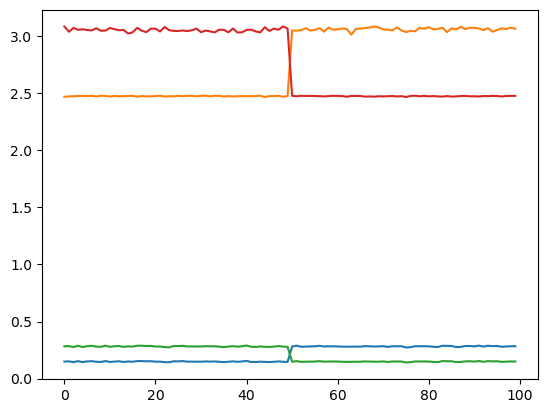

In [31]:
plt.plot(avg_moving_mean_stat_mov)
plt.plot(avg_moving_entropy_stat_mov)
plt.plot(avg_moving_mean_mov_stat)
plt.plot(avg_moving_entropy_mov_stat)
# plt.plot(avg_moving_MI)

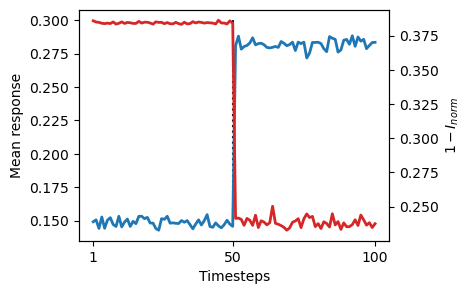

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax_right = ax.twinx()

x_ticks = np.arange(1, 101, 1)

stimulus_entropy = calc_entropy(stimuli, np.linspace(-3*stim_SD, 3*stim_SD, n_bins))

ax.vlines(T//(2*window_size), .15, .3, color='k', linestyle=':')
ax.plot(x_ticks, avg_moving_mean_stat_mov, color='tab:blue', linewidth=2)
ax.set_xticks([1, 50, 100])
ax_right.plot(x_ticks, 1 - avg_moving_entropy_stat_mov/stimulus_entropy, color='tab:red', linewidth=2)
# ax_right.set_ylim(0, 0.475)
# ax.set_ylim(0, 0.3)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean response')
ax_right.set_ylabel('$1-I_{norm}$')
plt.savefig('../cosyne_2025_figures/mineault_sim_stat_to_mov.pdf', bbox_inches='tight', format='pdf')
# ax.set_xlim(40, 60)

(100,)
(100,)


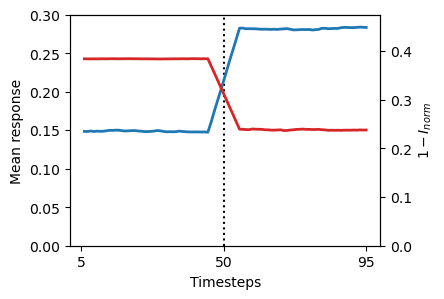

In [33]:
# smooth the responses and entropies with a boxcar filter
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax_right = ax.twinx()

stimulus_entropy = calc_entropy(stimuli, np.linspace(-3*stim_SD, 3*stim_SD, n_bins))
smooth_size = 10 # must be even
x_ticks = np.arange(1, 101, 1)
print(x_ticks.shape)
print(bn.move_mean(avg_moving_mean_stat_mov, window=smooth_size).shape)


ax.vlines(len(x_ticks)//2, 0, .3, color='k', linestyle=':')
ax.plot(x_ticks[smooth_size//2:-smooth_size//2], bn.move_mean(avg_moving_mean_stat_mov, window=smooth_size)[smooth_size:], color='tab:blue', linewidth=2)
ax.set_xticks([smooth_size//2, 50, 100-smooth_size//2])
ax_right.plot(x_ticks[smooth_size//2:-smooth_size//2], bn.move_mean(1 - avg_moving_entropy_stat_mov/stimulus_entropy, window=smooth_size)[smooth_size:], color='tab:red', linewidth=2)
ax_right.set_ylim(0, 0.475)
ax.set_ylim(0, 0.3)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean response')
ax_right.set_ylabel('$1-I_{norm}$')
plt.savefig('../cosyne_2025_figures/mineault_sim_stat_to_mov_smoothed.pdf', bbox_inches='tight', format='pdf')
# ax.set_xlim(40, 80)

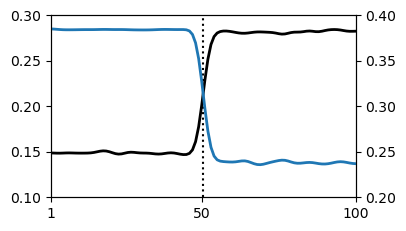

In [50]:
from scipy.ndimage import gaussian_filter
# smooth the responses and entropies with a boxcar filter
cm= 1/2.54
fig, ax = plt.subplots(1, 1, figsize=(10*cm, 6*cm))

ax_right = ax.twinx()

stimulus_entropy = calc_entropy(stimuli, np.linspace(-3*stim_SD, 3*stim_SD, n_bins))
sigma = 2 # size of Gaussian filter
x_ticks = np.arange(1, 101, 1)


ax.plot(x_ticks, gaussian_filter(avg_moving_mean_stat_mov, sigma=sigma), color='k', linewidth=2)
ax.set_xticks([1, 50, 100])
ax_right.plot(x_ticks, gaussian_filter(1 - avg_moving_entropy_stat_mov/stimulus_entropy, sigma=sigma), color='tab:blue', linewidth=2)
ax.vlines(len(x_ticks)//2+0.5, 0.1, 0.3, color='k', linestyle=':')
# ax_right.set_ylim(0, 0.475)
ax.set_ylim(0.1, 0.3)
ax.set_xlim(1, 100)
ax_right.set_ylim(0.2,0.4)
# ax.set_yticks([0.14, 0.28])
# ax_right.set_yticks([0.25, 0.4])
# ax.set_xlabel('Timesteps')
# ax.set_ylabel('firing rate')
# ax_right.set_ylabel('$1-I_{norm}$')
# plt.savefig('../cosyne_2025_figures/mineault_sim_stat_to_mov_gauss_smoothed.svg', bbox_inches='tight', format='svg')
plt.savefig('../manuscript_figures/fig2_mineault_sim_stat_to_mov_gauss_smoothed.pdf', bbox_inches='tight', format='pdf')
# ax.set_xlim(40, 80)

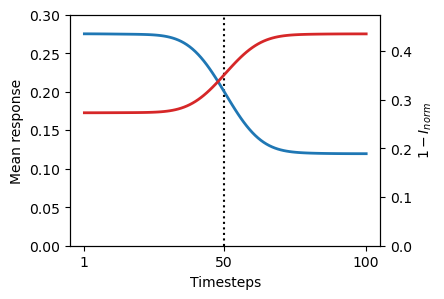

In [42]:
from scipy.ndimage import gaussian_filter
# smooth the responses and entropies with a boxcar filter
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax_right = ax.twinx()

stimulus_entropy = calc_entropy(stimuli, np.linspace(-3*stim_SD, 3*stim_SD, n_bins))
sigma = 10 # size of Gaussian filter
x_ticks = np.arange(1, 101, 1)


ax.vlines(len(x_ticks)//2, 0, .3, color='k', linestyle=':')
ax.plot(x_ticks, gaussian_filter(avg_moving_mean_mov_stat, sigma=sigma), color='tab:blue', linewidth=2)
ax.set_xticks([1, 50, 100])
ax_right.plot(x_ticks, gaussian_filter(1 - avg_moving_entropy_mov_stat/stimulus_entropy, sigma=sigma), color='tab:red', linewidth=2)
ax_right.set_ylim(0, 0.475)
ax.set_ylim(0, 0.3)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean response')
ax_right.set_ylabel('$1-I_{norm}$')
plt.savefig('../manuscript_figures/mineault_sim_mov_to_stat_gauss_smoothed.pdf', bbox_inches='tight', format='pdf')
# ax.set_xlim(40, 80)

# Linear decoding

In [14]:
# train a linear decoder to predict the stimuli based on the response

from sklearn.linear_model import LinearRegression

In [55]:
stationary_input = responses_stationary.reshape(-1, T).T
moving_input = responses_moving.reshape(-1, T).T

In [16]:
stationary_input.shape

(100000, 3456)

In [17]:
# train regression
stationary_regressor = LinearRegression()
stationary_regressor.fit(stationary_input[:50000], stimuli[:50000])

moving_regressor = LinearRegression()
moving_regressor.fit(moving_input[:50000], stimuli[:50000])


LinearRegression()

In [67]:
stationary_regressor.score(stationary_input, stimuli)

0.9999603670221654

In [68]:
moving_regressor.score(moving_input, stimuli)

0.9999999957872782

In [75]:
# compute the decoder error for each sample as the rms
stationary_decoder_error = (stationary_regressor.predict(stationary_input) - stimuli)**2
moving_decoder_error = (moving_regressor.predict(moving_input) - stimuli)**2

In [76]:
stationary_decoder_error.shape

(100000,)

In [77]:
# chunk the data and compute the mean decoder error for each chunk
stationary_decoder_error = stationary_decoder_error.reshape(-1, window_size, T//(window_size)).mean(axis=1)
moving_decoder_error = moving_decoder_error.reshape(-1, window_size, T//(window_size)).mean(axis=1)

# take the sqrt
stationary_decoder_error = np.sqrt(stationary_decoder_error)
moving_decoder_error = np.sqrt(moving_decoder_error)

In [78]:
stationary_decoder_error.shape

(1, 100)

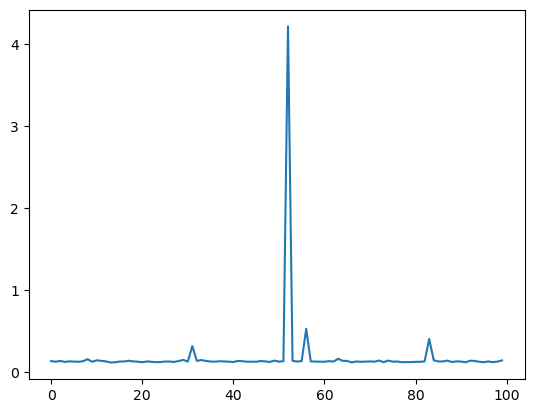

In [79]:
plt.plot(stationary_decoder_error[0], label='stationary decoder error')

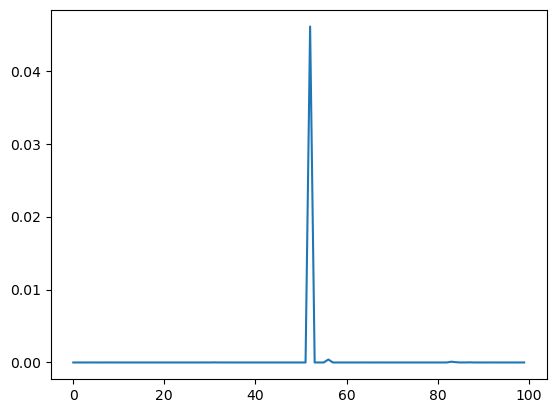

In [80]:
plt.plot(moving_decoder_error[0], label='moving decoder error')

In [81]:
# reshape to keep the last dimension the same but split the first dimension into two of size window_size
stationary_input_reshape = stationary_input[:50000, :].T.reshape(-1, window_size, T//(2*window_size))
moving_input_reshape = moving_input[:50000, :].T.reshape(-1, window_size, T//(2*window_size))

In [82]:
avg_moving_mean_mov = np.nanmean(moving_input_reshape, axis=(0, 1))
avg_moving_mean_stat = np.nanmean(stationary_input_reshape, axis=(0, 1))

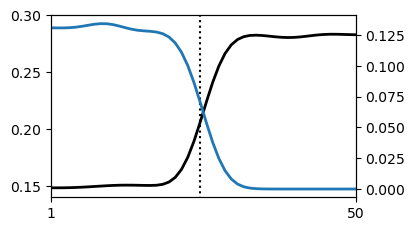

In [88]:
from scipy.ndimage import gaussian_filter
# smooth the responses and entropies with a boxcar filter
cm= 1/2.54
fig, ax = plt.subplots(1, 1, figsize=(10*cm, 6*cm))

ax_right = ax.twinx()

sigma = 3 # size of Gaussian filter
x_ticks = np.arange(1, 51, 1)


ax.plot(x_ticks, gaussian_filter(np.concatenate([avg_moving_mean_stat[:25], avg_moving_mean_mov[25:]]), sigma=sigma), color='k', linewidth=2)
ax.set_xticks([1, 50])
ax_right.plot(x_ticks, gaussian_filter(np.concatenate([stationary_decoder_error[0, :25], moving_decoder_error[0, 25:50]]), sigma=sigma), color='tab:blue', linewidth=2)
ax.vlines(len(x_ticks)//2, 0.1, 0.3, color='k', linestyle=':')
ax.set_ylim(0.14, 0.3)
ax.set_xlim(1, 50)
# ax_right.set_ylim(0,0.14)

# ax_right.set_ylim(0, 0.475)
# ax.set_yticks([0.14, 0.28])
# ax_right.set_yticks([0.25, 0.4])
# ax.set_xlabel('Timesteps')
# ax.set_ylabel('firing rate')
# ax_right.set_ylabel('$1-I_{norm}$')
# plt.savefig('../cosyne_2025_figures/mineault_sim_stat_to_mov_gauss_smoothed.svg', bbox_inches='tight', format='svg')
plt.savefig('../manuscript_figures/fig2_mineault_sim_stat_to_mov_gauss_smoothed_decoder.pdf', bbox_inches='tight', format='pdf')
# ax.set_xlim(40, 80)